In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from pmdarima.arima import auto_arima

from lager.auto_ml_forecasters.auto_forecaster import AutoForecaster
from lager.ml_forecasters.recursive_forecaster import RecursiveForecaster

%matplotlib inline

In [2]:
data=pd.read_csv('../data/ts.csv').dropna(how='any')

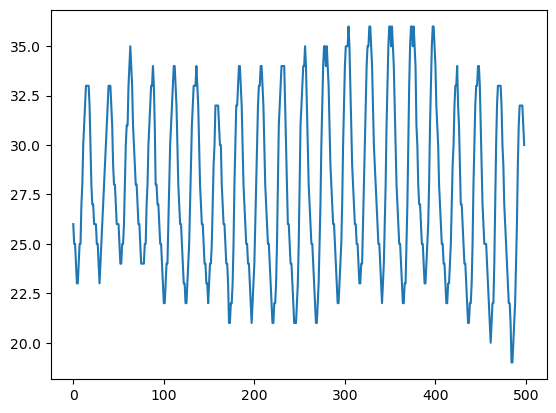

In [3]:
temperature = data['temperature']
temperature.plot();

## RecursiveForecaster

In [4]:
ts = np.array(temperature)
ts_train = ts[:451]
ts_val = ts[451:]
print(len(ts_train), len(ts_val))

451 48


In [5]:
R = RecursiveForecaster(ts=ts_train, regressor=LGBMRegressor(verbose=-1), num_features=24)

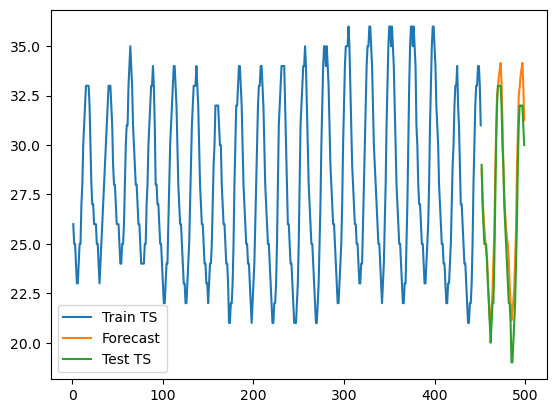

1.8320909011761664

In [6]:
R.forecast(length=len(ts_val));
R.plot(ts_test=ts_val)
R.get_metric(ts_test=ts_val)

## AutoForecaster

In [7]:
A = AutoForecaster(ts=ts_train, model_type='recursive', 
                   num_features=[24, 48, 72, 96], 
                   train_size=48*4,
                   test_size=48)

In [8]:
A.get_best_model()

RandomForestRegressor 24
RandomForestRegressor 48
RandomForestRegressor 72
RandomForestRegressor 96
LGBMRegressor 24
LGBMRegressor 48
LGBMRegressor 72
LGBMRegressor 96
DecisionTreeRegressor 24
DecisionTreeRegressor 48
DecisionTreeRegressor 72
DecisionTreeRegressor 96
LinearRegression 24
LinearRegression 48
LinearRegression 72
LinearRegression 96
Best regressor RandomForestRegressor() with 96 num_features; value of mse metric is 1.8756529166666662


In [9]:
A.get_validation_value(ts_val=ts_val)

Baseline metric: 42.583333333333336; regressor average metric after 10 trials: 1.9589725000000002.


1.9589725000000002

## auto_arima

In [10]:
a = auto_arima(y=ts_train, trace=True, seasonal=False) # making seasonal=False improves a lot
a_preds = a.predict(n_periods=len(ts_val))
print(mse(ts_val, a_preds))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1153.097, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4296.769, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3697.219, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1234.957, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1160.638, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=966.746, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1158.477, Time=0.05 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1159.848, Time=0.16 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1153.678, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1150.048, Time=0.06 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1076.436, Time=0.17 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=1166.954, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=993.839, Time=0.24 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]    

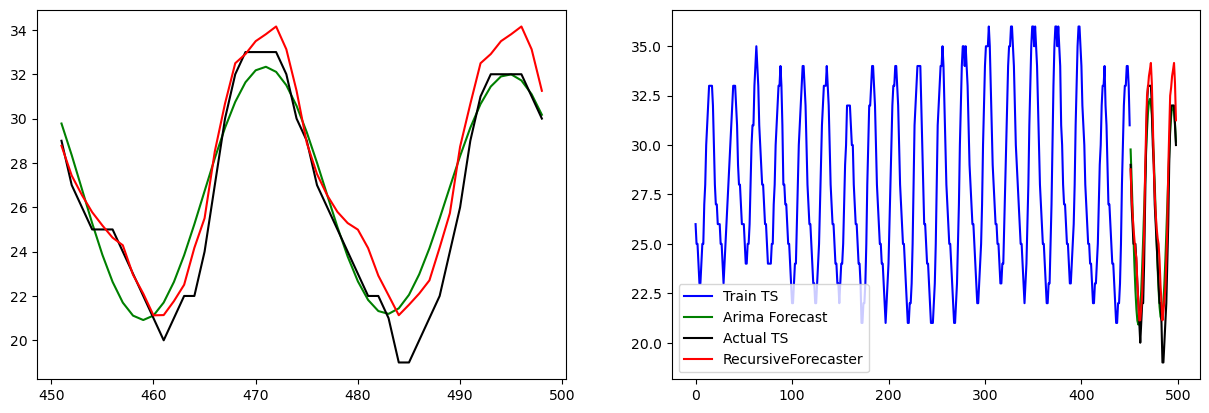

In [17]:
fig,ax = plt.subplots(1, 2)
train_range = range(len(ts_train))
val_range = range(len(ts_train), len(ts_train)+len(ts_val))

fig.set_figwidth(15)

ax[1].plot(train_range, ts_train, label="Train TS", color='blue')
ax[1].plot(val_range, a_preds, label = "Arima Forecast", color='green')
ax[1].plot(val_range, ts_val, label="Actual TS", color='black')
ax[1].plot(val_range, R.predictions, label="RecursiveForecaster", color='red')

ax[0].plot(val_range, a_preds, label = "Arima Forecast", color='green')
ax[0].plot(val_range, ts_val, label="Actual TS", color='black')
ax[0].plot(val_range, R.predictions, label="RecursiveForecaster", color='red')

plt.legend();